# Get data

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
dataDir = "/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles=['female_1.mat']

data = [] #processed and normalised with pose_idx
e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    signal = e**signal
    signal /= np.sum(signal)
    signal = np.clip(signal,1e-7,1e+7)
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = list((np.array(chn1).T)[-1].T.astype(int))

    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))
    # print(np.array(chn1).shape)
    print(label)
    # print('label[i]: ',label[i])
    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label[5]]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data




for file in dataFiles:
    data_path = dataDir+file
    print(data_path)
    mat = scipy.io.loadmat(data_path)
    mat.pop("__header__")
    mat.pop("__version__")
    mat.pop("__globals__")
    i=0
    for channel in mat: 
        if(i%2==0):
            channel2 =  channel[:-1]
            channel2 += '2'
            sigs1 = mat[channel] 
            sigs2 = mat[channel2]
            sigs1_norm = []
            sigs2_norm = []

            for signal in sigs1:
                signal = normalize_arr(signal,i)
                sigs1_norm.append(signal)
            for signal in sigs2:
                signal = normalize_arr(signal,i)
                sigs2_norm.append(signal)

            if i==0:
                data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                # print(data)
            else:
                None
                data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                data += data_lc
                # data = data_lc
        i+=1
print(np.array(data).shape)
print(data[-3])






/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/female_1.mat
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
(540000, 3)
[0.00029869612543525175, 0.0002797453486948402, 5]


In [123]:
import pandas as pd
import math  
def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    time = 0
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n
        time += 1

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        row =np.pad(row,(0,n-n_len),'constant')
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)

# print(df)
dataset = data.copy()
df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])
mask = np.random.rand(len(df)) < 0.8
dataset_t_v = df[mask] #test & val
dataset_test = df[~mask]

val_test_mask = np.random.rand(len(dataset_t_v)) < 0.5
dataset_train = dataset_t_v[val_test_mask]
dataset_val = dataset_t_v[~val_test_mask]

n=392
dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)
print(dataset_train_ar[-20:][-1])

np.random.shuffle(dataset_train_ar)
np.random.shuffle(dataset_test_ar)
np.random.shuffle(dataset_val_ar)

print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)


X_val = split_X(dataset_train_ar)
y_val = split_y(dataset_train_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_val = reshape_arr(X_val)
X_test = reshape_arr(X_test)

# OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

[3.57072468e-04 3.39317333e-04 3.66295635e-04 2.83843705e-04
 3.57072468e-04 2.83843705e-04 3.30773468e-04 3.06411434e-04
 4.16109628e-04 4.16109628e-04 2.69729810e-04 2.43572284e-04
 2.76696919e-04 2.98696125e-04 2.43572284e-04 3.06411434e-04
 3.06411434e-04 3.39317333e-04 4.16109628e-04 4.05632166e-04
 1.88745162e-04 4.05632166e-04 4.72698022e-04 3.39317333e-04
 2.49863746e-04 2.09014735e-04 4.97432443e-04 3.14326028e-04
 3.48081537e-04 3.85462439e-04 3.48081537e-04 3.66295635e-04
 3.48081537e-04 3.95418522e-04 2.62938129e-04 2.91175376e-04
 4.16109628e-04 3.30773468e-04 3.48081537e-04 3.66295635e-04
 3.57072468e-04 3.30773468e-04 2.37439476e-04 3.57072468e-04
 4.72698022e-04 3.14326028e-04 3.85462439e-04 2.49863746e-04
 3.30773468e-04 4.37883001e-04 3.75756660e-04 2.83843705e-04
 3.22444734e-04 3.22444734e-04 3.48081537e-04 3.75756660e-04
 2.91175376e-04 4.16109628e-04 3.95418522e-04 2.98696125e-04
 2.91175376e-04 3.22444734e-04 2.91175376e-04 4.05632166e-04
 3.57072468e-04 3.480815

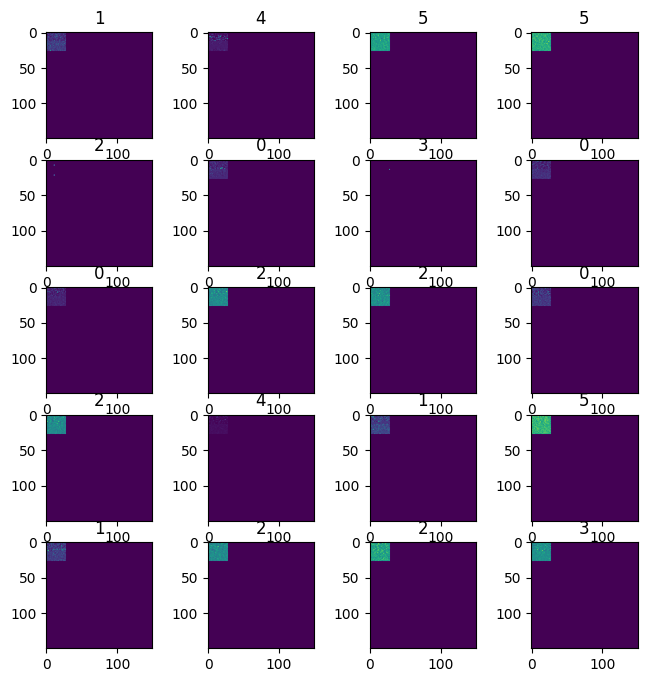

[1 4 5 5 2 0 3 0 0 2 2 0 2 4 1 5 1 2 2 3]


In [124]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X_tl[i-1])
plt.show()
print(y[:(columns*rows)])

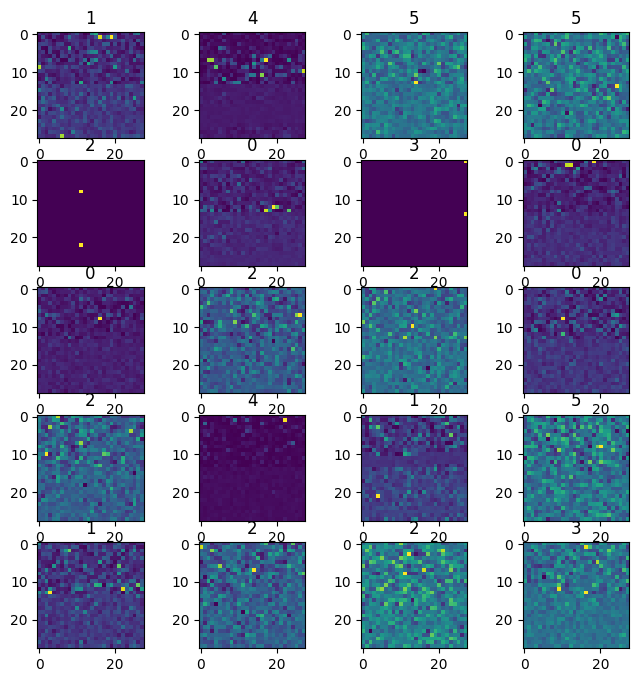

[1 4 5 5 2 0 3 0 0 2 2 0 2 4 1 5 1 2 2 3]


In [125]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X[i-1])
plt.show()
print(y[:(columns*rows)])

In [4]:
dataset_train

,channel1,channel2,label
0,0.000271,0.000368,0
7,0.000205,0.000359,0
8,0.000245,0.000350,0
10,0.000316,0.000308,0
11,0.000258,0.000324,0
...,...,...,...
539991,0.000406,0.000302,5
539993,0.000299,0.000326,5
539997,0.000299,0.000280,5
539998,0.000348,0.000352,5


# NN
## training & evaluate

In [5]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers

# inputs = keras.Input(shape=(392*2,1))
input_dim = int(math.sqrt(n*2))
inputs = keras.Input(shape=(input_dim,input_dim))

x = layers.Rescaling(2)(inputs)
x = layers.Flatten()(x)
# Apply some convolution and pooling layers
# x = layers.Flatten()(inputs)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
num_classes = 6
outputs = layers.Dense(num_classes, activation="softmax")(x)

2023-10-18 18:01:53.784210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 18:01:58.315349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-10-18 18:01:58.315489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Inspiron-7591
2023-10-18 18:01:58.315533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Inspiron-7591
2023-10-18 18:01:58.315790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 520.61.5
2023-10-18 18:01:58.315889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel repo

In [6]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 117766 (460.02 KB)
Trainable params: 117766 (46

In [7]:
# model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
#               loss=keras.losses.CategoricalCrossentropy())
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

batch_size = 64
epochs = 100
history = model.fit(X, y,batch_size=batch_size, epochs=epochs)


Epoch 1/100
9/9 [==============================] - 1s 4ms/step - loss: 1.8005
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 1.7667
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 1.7444
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 1.7255
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 1.7096
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6935
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6793
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6653
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6535
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6424
Epoch 11/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6326
Epoch 12/100
9/9 [==============================] - 0s 3ms/step - loss: 1.6262
Epoch 13/100
9/9 [==============================] - 0s 3ms/st

## visualise training history

In [8]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': 9}
dict_keys(['loss'])


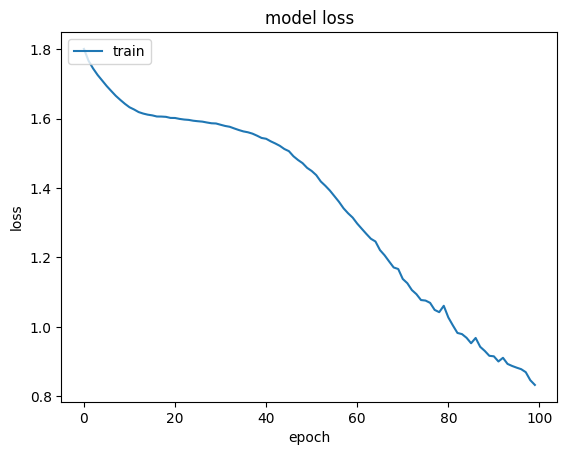

In [9]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
evaluate = model.evaluate(X_test,y_test)

9/9 [==============================] - 0s 2ms/step - loss: 38.2075


In [11]:
# model.save("./models/model_tuner.keras")

In [12]:
print('X,y shape: ',X.shape,'/',y.shape,"\nX,y test shape: ",X_test.shape,"/", y_test.shape)

X,y shape:  (551, 28, 28) / (551,) 
X,y test shape:  (275, 28, 28) / (275,)


## tuning with tuner

In [13]:
def build_model(hp):
    input_dim = int(math.sqrt(n*2))
    inputs = keras.Input(shape=(input_dim,input_dim))

    x = layers.Rescaling(2)(inputs)
    x = layers.Flatten()(x)
    # Apply some convolution and pooling layers
    # x = layers.Flatten()(inputs)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    num_classes = 6
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model


In [14]:
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    executions_per_trial=2,
    directory='my_dir')


Using TensorFlow backend


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28)            0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 117766 (460.02 KB)
Trainable params: 117766 (

In [15]:
tuner.search(X,y,epochs= 10, validation_data=(X_val,y_val))

In [16]:
models = tuner.get_best_models(num_models=2)

In [17]:
tuner.results_summary()

Results summary
Results in my_dir/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")


In [18]:
history = model.fit(X, y,batch_size=batch_size, epochs=epochs)


Epoch 1/100
9/9 [==============================] - 0s 4ms/step - loss: 0.8235
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.8266
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.8143
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.8155
Epoch 5/100
1/9 [==>...........................] - ETA: 0s - loss: 0.8418

9/9 [==============================] - 0s 4ms/step - loss: 0.8206
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.9117
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7902
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7860
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7760
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7732
Epoch 11/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7657
Epoch 12/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7642
Epoch 13/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7499
Epoch 14/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7485
Epoch 15/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7401
Epoch 16/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7394
Epoch 17/100
9/9 [==============================] - 0s 3ms/step - los

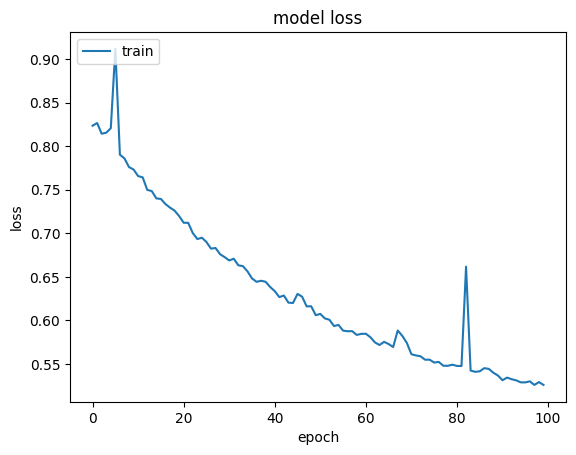

In [19]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# model.save("./models/model_tuner.keras")

In [21]:
evaluate = model.evaluate(X_test,y_test)

9/9 [==============================] - 0s 2ms/step - loss: 83.0140


## Transfer Learning
- RESNET50

OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

In [128]:
print(X[0].shape)
rgb_batch_ts =  np.repeat(X[0][..., np.newaxis], 3, -1)
rgb_batch_ts.shape

(28, 28)


(28, 28, 3)

In [101]:
def signal_to_3channelimg(arr):
    print(arr[0].shape)
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts

In [152]:
X_tl = signal_to_3channelimg(X_tl)
X_val_tl = signal_to_3channelimg(X_val_tl)
X_test_tl = signal_to_3channelimg(X_test_tl)

(100, 100, 3)


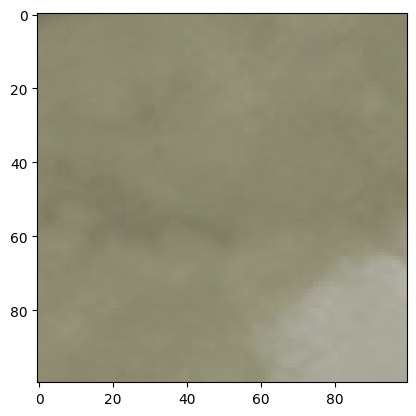

In [75]:
import cv2
imtest = cv2.imread('./test.jpg')
testl = 100
imtest = imtest[0:testl, 0:testl]
print(imtest.shape)
plt.imshow(cv2.cvtColor(imtest, cv2.COLOR_BGR2RGB))


In [141]:
#create basemodel and get it pre-trained para
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(150,150,3),
    include_top=False
    )
base_model.trainable = False    

In [134]:
# # Create new model on top.
# inputs = keras.Input(shape=(150, 150, 3))
# x = base_model(inputs, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
# optimizer = keras.optimizers.Adam()

In [144]:
inputs = keras.Input(shape=(150, 150, 3))


# x = layers.Rescaling(2)(inputs)
# x = layers.Flatten()(x)
x = base_model(inputs, training=False)

# Apply some convolution and pooling layers
# x = layers.Flatten()(inputs)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

x = keras.layers.GlobalAveragePooling2D()(x)

num_classes = 6

# outputs = layers.Dense(num_classes, activation="softmax")(x)

x = layers.Dense(num_classes, activation="softmax")(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(6)(x)  # Regularize with dropout
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 dense_18 (Dense)            (None, 5, 5, 128)         262272    
                                                                 
 dense_19 (Dense)            (None, 5, 5, 128)         16512     
                                                                 
 global_average_pooling2d_2  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 6)                 774       
                                                           

In [153]:
X_tl.shape


(551, 150, 150, 3)

In [154]:
# model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.sparse_categorical_crossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

epochs = 20
# history_tl = model.fit((X_tl,y), epochs=epochs, validation_data=(X_val_tl,y_val))
history_tl = model.fit(X_tl, y,batch_size=batch_size, epochs=epochs)


Epoch 1/20


2023-10-19 00:26:15.669815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 148770000 exceeds 10% of free system memory.


9/9 [==============================] - 16s 1s/step - loss: 5.6523
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: 4.6337
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 4.6293
Epoch 4/20
9/9 [==============================] - 12s 1s/step - loss: 4.7804
Epoch 5/20
9/9 [==============================] - 12s 1s/step - loss: 4.7249
Epoch 6/20
9/9 [==============================] - 12s 1s/step - loss: 4.5509
Epoch 7/20
9/9 [==============================] - 12s 1s/step - loss: 4.7130
Epoch 8/20
9/9 [==============================] - 12s 1s/step - loss: 3.7556
Epoch 9/20
9/9 [==============================] - 12s 1s/step - loss: 3.5935
Epoch 10/20
9/9 [==============================] - 12s 1s/step - loss: 3.8608
Epoch 11/20
9/9 [==============================] - 12s 1s/step - loss: 3.6067
Epoch 12/20
9/9 [==============================] - 12s 1s/step - loss: 3.9169
Epoch 13/20
9/9 [==============================] - 12s 1s/step - loss: 3.6813
Epoch 

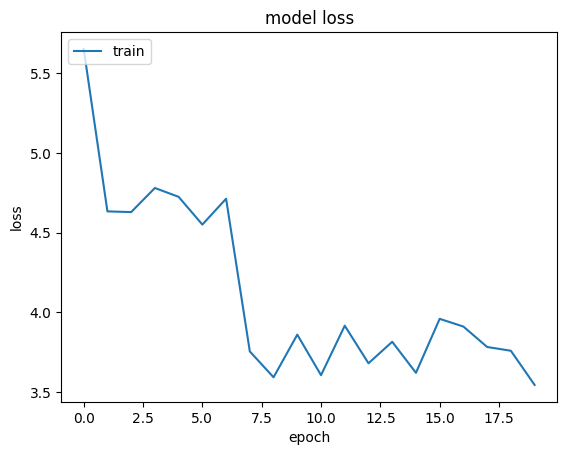

In [155]:

# summarize history for loss
plt.plot(history_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [158]:
model.evaluate(X_test_tl,y_test)

9/9 [==============================] - 7s 679ms/step - loss: 4.1100


4.109955787658691

# ALGO
## Random Forest

In [22]:
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf


In [23]:
dataset_train

,channel1,channel2,label
0,0.000271,0.000368,0
7,0.000205,0.000359,0
8,0.000245,0.000350,0
10,0.000316,0.000308,0
11,0.000258,0.000324,0
...,...,...,...
539991,0.000406,0.000302,5
539993,0.000299,0.000326,5
539997,0.000299,0.000280,5
539998,0.000348,0.000352,5


In [53]:
print(dataset_test_ar[0][-1])
column_name =np.array(list(range(n*2+1)))
column_name=column_name+1
column_name=column_name.astype('str')
column_name
us = pd.DataFrame(dataset_test_ar,columns=column_name)

5.0


In [54]:
us

,1,2,3,4,5,6,7,8,9,10,...,776,777,778,779,780,781,782,783,784,785
0,0.000350,0.000333,0.000350,0.000359,0.000350,0.000286,0.000500,0.000368,0.000308,0.000408,...,0.000318,0.000352,0.000310,0.000310,0.000273,0.000326,0.000343,0.000318,0.000294,5.0
1,0.000300,0.000308,0.000358,0.000324,0.000341,0.000300,0.000324,0.000316,0.000300,0.000324,...,0.000326,0.000370,0.000326,0.000326,0.000310,0.000390,0.000326,0.000380,0.000334,5.0
2,0.000374,0.000383,0.000249,0.000393,0.000297,0.000313,0.000290,0.000297,0.000268,0.000329,...,0.000398,0.000300,0.000324,0.000388,0.000245,0.000368,0.000359,0.000333,0.000388,2.0
3,0.000161,0.000193,0.000188,0.000268,0.000374,0.000268,0.000508,0.000125,0.000305,0.000193,...,0.000500,0.000300,0.000387,0.000429,0.000316,0.000300,0.000205,0.000264,0.000292,0.0
4,0.000288,0.000296,0.000327,0.000433,0.000402,0.000202,0.000281,0.000295,0.000311,0.000319,...,0.000352,0.000334,0.000361,0.000343,0.000326,0.000380,0.000361,0.000361,0.000343,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0.000431,0.000287,0.000302,0.000310,0.000420,0.000259,0.000334,0.000246,0.000389,0.000370,...,0.000333,0.000324,0.000350,0.000300,0.000300,0.000316,0.000324,0.000316,0.000333,2.0
271,0.000278,0.000034,0.000271,0.000002,0.001533,0.000462,0.000180,0.000257,0.000003,0.000204,...,0.000365,0.000283,0.000339,0.000395,0.000174,0.000262,0.000415,0.000314,0.000347,1.0
272,0.000213,0.000241,0.000468,0.000354,0.000392,0.000345,0.000202,0.000320,0.000304,0.000289,...,0.000333,0.000359,0.000368,0.000316,0.000308,0.000316,0.000368,0.000300,0.000341,2.0
273,0.000204,0.000323,0.000323,0.000323,0.000473,0.000244,0.000386,0.000511,0.000427,0.000291,...,0.000333,0.000293,0.000368,0.000333,0.000359,0.000300,0.000285,0.000316,0.000388,2.0


In [57]:
# # Train a Gradient Boosted Trees model.
# model = tfdf.keras.GradientBoostedTreesModel(num_trees=1500)
lbel_index = n*n
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(us,label=str(n*2+1))

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_1.fit(train_ds)


Use 12 thread(s) for training
Use /tmp/tmpypargjfi as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, '2': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, '3': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, '4': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, '5': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, '6': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, '7': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, '8': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, '9': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, '10': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, '11': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, '12': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, '13': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, '14': <tf.Tensor 'data_13:0' shape=(None,) dtype=float64>, '15': <tf.Tensor 'data_14:0' shape=(None,) dtyp

[INFO 23-10-18 21:26:00.2880 +07 kernel.cc:773] Start Yggdrasil model training
[INFO 23-10-18 21:26:00.2880 +07 kernel.cc:774] Collect training examples
[INFO 23-10-18 21:26:00.2881 +07 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-10-18 21:26:00.2933 +07 kernel.cc:393] Number of batches: 1
[INFO 23-10-18 21:26:00.2933 +07 kernel.cc:394] Number of examples: 275
[INFO 23-10-18 21:26:00.2963 +07 kernel.cc:794] Training dataset:
Number of records: 275
Number of columns: 785

Number of columns by type:
	NUMERICAL: 784 (99.8726%)
	CATEGORICAL: 1 (0.127389%)

Columns:

NUMERICAL: 784 (99.8726%)
	0: "1" NUMERICAL mean:0.000328014 min:1.02701e-05 max

Model trained in 0:00:00.912107
Compiling model...
Model compiled.


In [58]:
model_1.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (784):
	1
	10
	100
	101
	102
	103
	104
	105
	106
	107
	108
	109
	11
	110
	111
	112
	113
	114
	115
	116
	117
	118
	119
	12
	120
	121
	122
	123
	124
	125
	126
	127
	128
	129
	13
	130
	131
	132
	133
	134
	135
	136
	137
	138
	139
	14
	140
	141
	142
	143
	144
	145
	146
	147
	148
	149
	15
	150
	151
	152
	153
	154
	155
	156
	157
	158
	159
	16
	160
	161
	162
	163
	164
	165
	166
	167
	168
	169
	17
	170
	171
	172
	173
	174
	175
	176
	177
	178
	179
	18
	180
	181
	182
	183
	184
	185
	186
	187
	188
	189
	19
	190
	191
	192
	193
	194
	195
	196
	197
	198
	199
	2
	20
	200
	201
	202
	203
	204
	205
	206
	207
	2

# Bluetooth <placeholder>

In [26]:
import bluetooth

nearby_devices = bluetooth.discover_devices(lookup_names=True)
print("Found {} devices.".format(len(nearby_devices)))

for addr, name in nearby_devices:
    print("  {} - {}".format(addr, name))

Found 0 devices.
